In [30]:
import random
import math
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Generate Data
def GenerateData(select):
    random.seed(100)
    if select == 1:
        CL1 = 7
        CL2 = 7
        data = np.zeros((14,2))
        for i in range(0,CL1+1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1+1,CL2+CL1):
            data[i,0] = 3 + random.random()
            data[i,1] = 3 + random.random()
    elif select == 2:
        CL1 = 7
        CL2 = 7
        CL3 = 7
        data = np.zeros((21,2))
        for i in range(0,CL1+1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1+1,CL2+CL1+1):
            data[i,0] = 3 + random.random()
            data[i,1] = 1 + random.random()

        for i in range(CL2+CL1+1,CL3+CL2+CL1):
            data[i,0] = 1.5 + random.random()
            data[i,1] = 3 + random.random()
    return data

In [7]:
def CalculateAffinity(data):
    sigma = 1
    col_size = data.shape[0]
    affinity = np.zeros((col_size,col_size))
    for i in range(col_size):
        for j in range(col_size):
            dist = math.sqrt((data[i,0]-data[j,0])**2 + (data[i, 1] - data[j,1])**2)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    return affinity

In [35]:
def Weiss(k):
    #  generate the data, calculate the affinity 
    data = GenerateData(2)
    affinity = CalculateAffinity(data)

    # compute the degree matrix
    D =  np.zeros((affinity.shape))
    for i in range(affinity.shape[0]):
        D[i,i] = sum(affinity[i,:])


        #compute the normalized laplacian / affinity matrix (method 1)
    NL1 = np.zeros((affinity.shape))
    for i in range(affinity.shape[0]):
         for j in range(affinity.shape[1]):
                NL1[i,j] = affinity[i,j]/(math.sqrt(D[i,i]*math.sqrt(D[j,j])))

    eigvalue,eigvector = la.eig(NL1)
    sort_index = np.argsort(eigvalue)
    new_eigvec = eigvector[:,sort_index[-k:][::-1]]

    
    new_eigvec = eigvector[:,(eigvector.shape[0]-(k-1)):(eigvector.shape[0]+1)]

In [166]:
data = GenerateData(2)
affinity = CalculateAffinity(data)

# compute the degree matrix
D =  np.zeros((affinity.shape))
for i in range(affinity.shape[0]):
    D[i,i] = sum(affinity[i,:])


#compute the normalized laplacian / affinity matrix (method 1)
NL1 = np.zeros((affinity.shape))
for i in range(affinity.shape[0]):
    for j in range(affinity.shape[1]):
        NL1[i,j] = affinity[i,j]/(math.sqrt(D[i,i]*math.sqrt(D[j,j])))
k = 3
eigvalue,eigvector = la.eig(NL1)
sort_index = np.argsort(eigvalue)
new_eigvec = eigvector[:,sort_index[-k:][::-1]]

#construct the normalized matrix U from the obtained eigen vectors
U = np.zeros((new_eigvec.shape))
for i in range(new_eigvec.shape[0]):
    n = math.sqrt(sum(new_eigvec[i,:]**2));   
    U[i,:] = new_eigvec[i,:]/n 

When n_clusters = 3 , we have the best silhouette_score = 0.858093456711


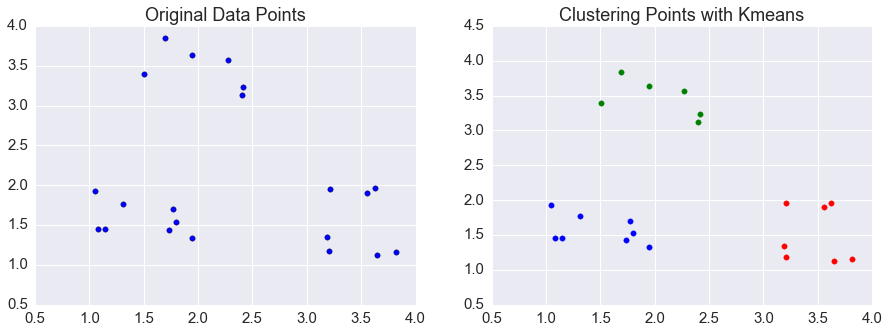

In [173]:
# First method: Kmeans

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

# select the four predicators in iris, create the unsupervised form
X=U

# generate the possible range 
clusters =range(2,8)

all_score = []
for item in clusters:

    # Initialize the clusterer with n_clusters value in clusters
    clusterer = KMeans(n_clusters=item, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels)
    all_score.append(silhouette_avg)

# Find the max silhouette score
Num_cluster = [i+2 for i, j in enumerate(all_score) if j == max(all_score)]

   
print("When n_clusters =", str(Num_cluster).strip('[]'),
          ", we have the best silhouette_score =", max(all_score))

answer=str(Num_cluster).strip('[]')

# Make a pairwise scatter plot
clust_result = KMeans(n_clusters=int(answer), random_state=10)
cluster_labels = clust_result.fit_predict(X)
indicator=np.loadtxt(cluster_labels,dtype='int32')
ID=indicator.tolist()
IDX=np.asarray(ID) 


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
    elif IDX[i] == 2:
        plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points with Kmeans')
plt.show()


